# Homework (Week 3) -- Biometrics (20 points)

In this homework we train Biometrics Verification model and use some features to increase quality:
1) Train ECAPA-TDNN (10 points)
2) Any contrastive loss (10 points)

Link to download dataset: https://disk.yandex.ru/d/lyhtieYbxQOYqw

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import tqdm.notebook as tqdm
import urllib

import dataset

from IPython.display import clear_output

%matplotlib inline

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/lyhtieYbxQOYqw'
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_url

'https://downloader.disk.yandex.ru/disk/d677700dbfa24f6fcddd2df59aa78372349d044bac143a9ba0e1602b1b0b6793/6828f406/gtj3WQiuHGabqHv6W0pVHGRnXFJAW27izLLMm2MbHXViekKTxmGtGgT-Cdced2Nyo5eSrwwUCF_GbUu7CV3RNA%3D%3D?uid=0&filename=voxceleb.tar.gz&disposition=attachment&hash=UbepA8Q9HDxeFKWCa8Y0tO7K9asCmTAjTZtG1dex6z7oEbCbmS7yu53hGphcr8rhq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fx-gzip&owner_uid=163052607&fsize=7150565898&hid=d5bd9cc88bda4eba5b285b6d33a11c38&media_type=compressed&tknv=v3'

In [3]:
!wget -O voxceleb.tar.gz 'https://downloader.disk.yandex.ru/disk/b6f58a830b071d80f3ab22160670a31f3ae0b460e595283a0857afb074ba768c/67c46bcd/gtj3WQiuHGabqHv6W0pVHGRnXFJAW27izLLMm2MbHXViekKTxmGtGgT-Cdced2Nyo5eSrwwUCF_GbUu7CV3RNA%3D%3D?uid=0&filename=voxceleb.tar.gz&disposition=attachment&hash=UbepA8Q9HDxeFKWCa8Y0tO7K9asCmTAjTZtG1dex6z7oEbCbmS7yu53hGphcr8rhq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fx-gzip&owner_uid=163052607&fsize=7150565898&hid=d5bd9cc88bda4eba5b285b6d33a11c38&media_type=compressed&tknv=v2'
!tar -xf voxceleb.tar.gz

--2025-05-17 16:39:56--  https://downloader.disk.yandex.ru/disk/b6f58a830b071d80f3ab22160670a31f3ae0b460e595283a0857afb074ba768c/67c46bcd/gtj3WQiuHGabqHv6W0pVHGRnXFJAW27izLLMm2MbHXViekKTxmGtGgT-Cdced2Nyo5eSrwwUCF_GbUu7CV3RNA%3D%3D?uid=0&filename=voxceleb.tar.gz&disposition=attachment&hash=UbepA8Q9HDxeFKWCa8Y0tO7K9asCmTAjTZtG1dex6z7oEbCbmS7yu53hGphcr8rhq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fx-gzip&owner_uid=163052607&fsize=7150565898&hid=d5bd9cc88bda4eba5b285b6d33a11c38&media_type=compressed&tknv=v2
Resolving downloader.disk.yandex.ru (downloader.disk.yandex.ru)... 77.88.21.127, 2a02:6b8::2:127
Connecting to downloader.disk.yandex.ru (downloader.disk.yandex.ru)|77.88.21.127|:443... connected.
HTTP request sent, awaiting response... 410 Gone
2025-05-17 16:39:56 ERROR 410: Gone.



Exception: Process exited with code 8

### Some model train example

In [2]:
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu' # "cpu" for cpu, also you can use "cuda" for gpu and "mps" for apple silicon
DATADIR = './'
FEATS = 80
LOADER_WORKERS = 8

In [3]:
transform = torchaudio.transforms.MFCC(n_mfcc=FEATS) # You can try some other transformations here
trainset = dataset.Dataset(os.path.join(DATADIR, 'voxceleb_train'), transform)
testset = dataset.Dataset(os.path.join(DATADIR, 'voxceleb_test'), transform)
test_targets = pd.read_csv(os.path.join(DATADIR, 'target.csv')).values.tolist()

/Users/anymax/miniconda3/envs/speech_env/lib/python3.9/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


### Models

In [4]:
class Model(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden: int, kernel: int = 7, sride: int = 2):
        super().__init__()
        self._emb = nn.Sequential(
            nn.Conv1d(input_shape, hidden, kernel, stride=sride),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel, stride=sride),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel, stride=sride),
            nn.AdaptiveMaxPool1d(1),
        )
        self._final = nn.Sequential(
            nn.Linear(hidden, output_shape),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, X) -> tuple[torch.Tensor, torch.Tensor]:
        emb = self._emb(X).squeeze(2)
        return self._final(emb), emb

### Metrics

Cosine similarity:
$CS(a, b) = \frac{<a, b>}{\|a\| \|b\|}$

In [5]:
def cosine_similarity(a, b):
    a = a.reshape(-1)
    b = b.reshape(-1)
    return np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b)

Here is O(N log N) algorithm for find best_eer:
1) Sort prediction by probability
2) Going through items and recalculating far and frr

In [6]:
def best_eer(data):
    full = sorted(data, key=lambda x: (x[0], -x[1]))
    pos = len([item for item in full if item[1] == 1])
    neg = len(full) - pos
    cur_pos = pos
    cur_neg = 0
    best_eer = 1
    for _, label in full:
        if label == 1:
            cur_pos -= 1
        else:
            cur_neg += 1
        cur_eer = max((pos - cur_pos) / pos, (neg - cur_neg) / neg)
        best_eer = min(best_eer, cur_eer)
    return best_eer

### Train

In [7]:
def train_stage(model, opt, batch_size: int = 256):
    loader = torch_data.DataLoader(
        trainset,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    loss_sum = 0.0
    batches = 0
    for X, Y, _ in tqdm.tqdm(loader):
        logits, _ = model.forward(X.to(DEVICE))
        # print("shape logits: ", logits.shape)
        # print(logits)
        loss = F.nll_loss(logits.to(DEVICE), Y.to(DEVICE))
        # print("loss: ", loss)
        loss_sum += loss.item()
        batches += 1
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss_sum / batches

In [8]:
def calc_eval_score(model: nn.Module, batch_size: int = 256):
    loader = torch_data.DataLoader(
        testset,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    items = {}
    target_scores = []
    with torch.no_grad():
        for X, _, pathes in tqdm.tqdm(loader):
            _, embds = model.forward(X.to(DEVICE))
            embds = embds.cpu().data.numpy().reshape(X.shape[0], -1)
            for embd, path in zip(embds, pathes):
                items[path] = embd
    for item1, item2, target in test_targets:
        # if item1 not in items or item2 not in items:
        #     continue
        target_scores.append((cosine_similarity(items[item1], items[item2]), target))
    return best_eer(target_scores)

In [9]:
def train(
    model: nn.Module,
    opt,
    batch_size: int = 256,
    epochs: int = 10,
    train_fun = train_stage,
    train_kwargs = {},
):
    train_losses = []
    eval_scores = []
    for epoch in range(epochs):
        model.train()
        train_losses.append(train_fun(model, opt, batch_size=batch_size))
        model.eval()
        eval_scores.append(calc_eval_score(model, batch_size=batch_size))
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train CE loss')
        axis[1].plot(np.arange(1, epoch + 2), eval_scores, label='eval')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='EER')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}. Train loss {train_losses[-1]}. Eval score {eval_scores[-1]}')

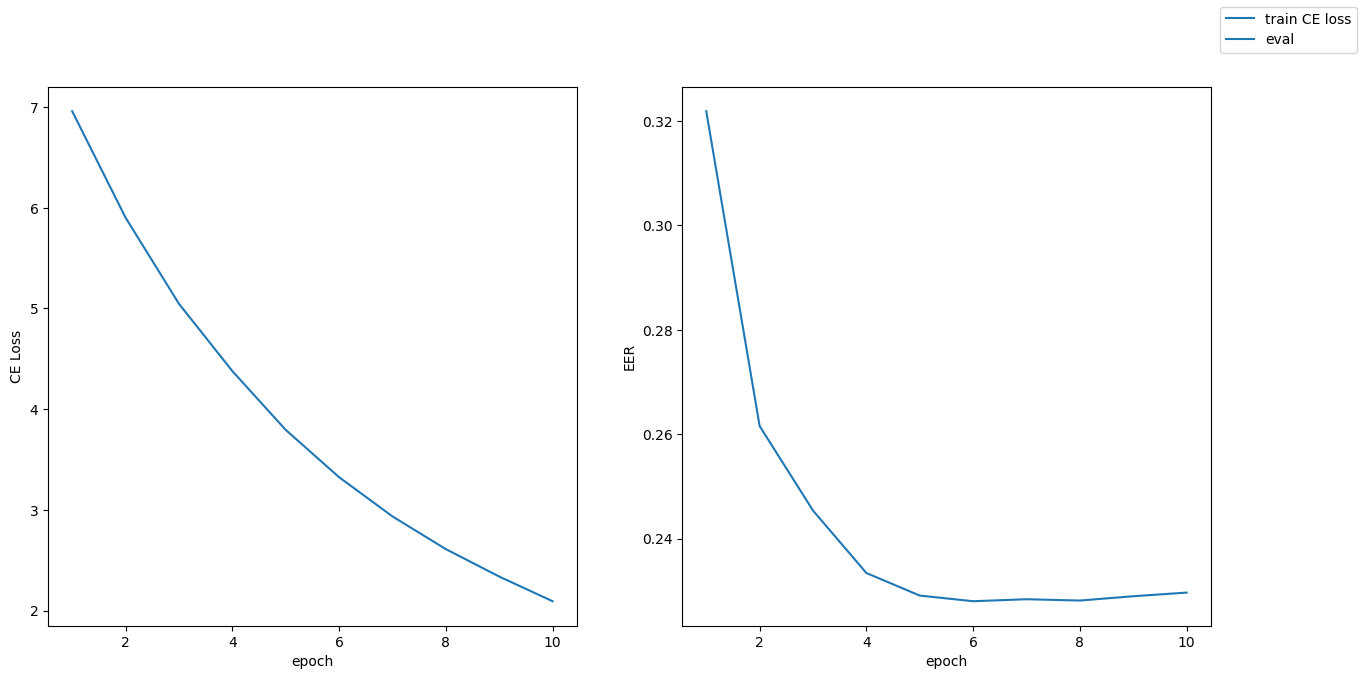

Epoch 10. Train loss 2.0930984528559557. Eval score 0.22963951935914553


In [10]:
model = Model(FEATS, trainset.speakers(), 128).to(DEVICE)
opt = optim.Adam(model.parameters())
train(model, opt)

### ECAPA TDNN (10 points)

Paper: https://arxiv.org/pdf/2005.07143.pdf

Papers for ECAPA parts:
- SE-Blocks - https://arxiv.org/pdf/1709.01507.pdf
- Res2Net - https://arxiv.org/pdf/1904.01169.pdf
- Attentive Stats Pooling - https://arxiv.org/pdf/1803.10963.pdf
- AAM Softmax - https://arxiv.org/pdf/1906.07317.pdf

Also you can optionally add other settings for paper:
- SpecAug
- Weight decay for optimizer
- LR scheduler

In [11]:
class SEBlock(nn.Module):
    def __init__(self, input_shape: int, reduction: int):
        super().__init__()
        self.input_shape = input_shape
        self.reduction = reduction
        # self.after_reduction = self.input_shape // self.reduction
        self.after_reduction = reduction
        
        self.squeeze = nn.AdaptiveAvgPool1d(output_size=1)
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.fc1 = nn.Conv1d(
            in_channels=self.input_shape,
            out_channels=self.after_reduction,
            kernel_size=1,
        )
        self.fc2 = nn.Conv1d(
            in_channels=self.after_reduction,
            out_channels=self.input_shape,
            kernel_size=1,
        )

    def __call__(self, X):
        s = self.sigm(self.fc2(self.relu(self.fc1(self.squeeze(X)))))
        x = X * s
        return x
        

In [18]:
class Res2Net(nn.Module):
    def __init__(self, hidden: int, dilation: int, scale: int):
        super().__init__()
        assert hidden % scale == 0
        self.hidden = hidden
        self.dilation = dilation
        self.scale = scale
        
        self.conv1 = nn.Conv1d(self.hidden, self.hidden * self.scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(self.hidden * self.scale)
        conv_list = []
        bn_list = []
        for _ in range(self.scale - 1):
            conv_list.append(nn.Conv1d(self.hidden, self.hidden, kernel_size=3, padding="same", dilation=self.dilation))
            bn_list.append(nn.BatchNorm1d(self.hidden))
        self.conv_list = nn.ModuleList(conv_list)
        self.bn_list = nn.ModuleList(bn_list)
        
        self.conv2 = nn.Conv1d(self.hidden * self.scale, self.hidden, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm1d(self.hidden)
        self.relu = nn.ReLU()

    def __call__(self, X):
        out = self.bn1(self.relu(self.conv1(X)))
        
        x = torch.split(out, self.hidden, dim=1)
        for i in range(len(x)):
            elem = x[i]
            if i == 0:
                out = elem
                continue
            if i == 1:
                result = elem
            else:
                result = result + elem
            result = self.conv_list[i - 1](result)
            result = self.bn_list[i - 1](self.relu(result))
            out = torch.cat((out, result), axis=1)
        
        out = self.bn2(self.relu(self.conv2(out)))
        return out

In [13]:
class EcapaBlock(nn.Module):
    def __init__(self, hidden: int, dilation: int, scale: int):
        super().__init__()
        self.res2net = Res2Net(hidden, dilation, scale)
        self.se = SEBlock(hidden, 128)

    def __call__(self, X):
        out = self.se(self.res2net(X))
        out = out + X
        return out

In [14]:
class AttentiveStatsPooling(nn.Module):
    def __init__(self, input_shape: int, hidden: int):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_shape * 3, hidden),
            nn.Tanh(),
            nn.Linear(hidden, input_shape),
            nn.Softmax(dim=1),
        )

    def __call__(self, X):
        # X shape = [time, feats]
        # calc mean and std for X over time dimension
        x_mean = torch.mean(X, dim=1, keepdim=True)
        x_std = torch.sqrt(torch.var(X, dim=1, keepdim=True).clamp(min=2e-8))
        # concatenate mean and std to X over feats dimension to make shape [time, feats * 3]
        x_concated = torch.cat((X, x_mean.repeat(1, X.size(1), 1), x_std.repeat(1, X.size(1), 1)), dim=2) # [batch_size, time, feats * 3]
        # attention
        weights = self.attention(x_concated) # [batch_size, time, feats]
        # weighted mean and std with weights from attention for original X
        x_mean_mu = torch.sum(X * weights, dim=1)
        x_std = torch.sqrt((torch.sum(X * X * weights, dim=1) - x_mean_mu * x_mean_mu).clamp(min=2e-8))
        if torch.isnan(x_std).any():
            print("nan in AttentiveStatsPooling std")
        out = torch.cat((x_mean_mu, x_std), axis=1)
        # print("out attn_pool: ", out.shape)
        return out
        

In [15]:
class AAMSoftmax(nn.Module):
    def __init__(self, input_shape, n_class, margin, scale):
        super().__init__()
        self.input_shape = input_shape
        self.n_class = n_class
        self.m = margin
        self.s = scale
        
        self.weights = torch.nn.Parameter(torch.FloatTensor(self.n_class, self.input_shape), requires_grad=True)
        nn.init.xavier_normal_(self.weights)

    def forward(self, X):
        X_norm = F.normalize(X) # [batch_size, 192]
        W_norm = F.normalize(self.weights)
        # calc cosine similarity between X and weights
        cosine_sim = F.linear(X_norm, W_norm) # [batch_size, n_class]
        # theta = angle from cosine similarity
        theta = torch.acos(cosine_sim.clamp(-1.0, 1.0))
        phi = torch.exp(self.s * torch.cos(theta))
        phi_with_m = torch.exp(self.s * torch.cos(theta + self.m)) # scale * cos{theta_ii + margin}
        # output = torch.zeros(*phi_with_m.shape, requires_grad=True)
        output = torch.log((phi_with_m / (phi_with_m + torch.sum(phi, dim=1).unsqueeze(1).repeat(1, self.n_class) - phi)).clamp(min=2e-8))
        # for i in range(output.shape[0]):
        #     for j in range(output.shape[1]):
        #         output[i][j] = torch.log((phi_with_m[i][j] / (phi_with_m[i][j] + torch.sum(phi, dim=1)[i] - phi[i][j])).clamp(min=2e-4))
        # print("min after log: ", torch.min(output))
        # return matrix S, where S_ij = 
        #     \log \frac{
        #         \exp{scale \cos{theta_ij + margin}}
        #     }{
        #         \exp{scale \cos{theta_ij + margin}} + \sum_{k != j} \exp{scale \cos{theta_ij}}
        #     }
        return output # [batch_size, n_class]

In [16]:
class EcapaTDNN(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        self.hidden = 512
        
        self.layer1 = nn.Sequential(
            nn.Conv1d(input_shape, self.hidden, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.BatchNorm1d(self.hidden),
        )
        self.layer2 = EcapaBlock(self.hidden, 2, 8)
        self.layer3 = EcapaBlock(self.hidden, 3, 8)
        self.layer4 = EcapaBlock(self.hidden, 4, 8)
        
        self.layer5 = nn.Sequential(
            nn.Conv1d(self.hidden * 3, self.hidden * 3, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm1d(self.hidden * 3),
        )
        
        self.attn_pool = AttentiveStatsPooling(self.hidden * 3, 128)
        self.bn1 = nn.BatchNorm1d(self.hidden * 3 * 2)
        
        self.layer6 = nn.Sequential(
            nn.Linear(self.hidden * 3 * 2, 192),
            nn.BatchNorm1d(192),
        )
        
        self.aamsoftmax = AAMSoftmax(192, output_shape, 0.2, 30)
        

    def forward(self, X):
        # input = [batch_size, feats, T]
        # print("X shape: ", X.shape)
        if torch.isnan(X).any(): print("NaN in input_tensor")
        out = self.layer1(X) # [batch_size, hidden, T]
        # print("after self.layer1: ", out.shape)
        if torch.isnan(out).any(): print("NaN in first batch norm")
        
        out_1 = self.layer2(out) + out
        # print("after self.layer2: ", out_1.shape)
        if torch.isnan(out_1).any(): print("NaN in out_1")
        out_2 = self.layer3(out_1) + out_1
        # print("after self.layer3: ", out_2.shape)
        if torch.isnan(out_2).any(): print("NaN in out_2")
        out_3 = self.layer4(out_2) + out_2
        # print("after self.layer4: ", out_3.shape)
        if torch.isnan(out_3).any(): print("NaN in out_3")
        out = torch.cat([out_1, out_2, out_3], dim=1) # [batch_size, hidden * 3 = feats, T]
        # print("after se_blocks: ", out.shape)
        
        out = self.layer5(out)
        # print("after self.layer5: ", out.shape)
        if torch.isnan(out).any(): print("NaN in layer5")
        out = out.transpose(1, 2) # [batch_size, T, hidden * 3 = feats]
        out = self.bn1(self.attn_pool(out))
        # print("after attn_pool: ", out.shape)
        if torch.isnan(out).any(): print("NaN after attn_pool")
        
        out = self.layer6(out) # [batch_size, 192, 1]
        # print("after self.layer6: ", out.shape)
        
        loss = self.aamsoftmax(out)
        
        return loss, out

Train ECAPA model, at this point you can archive stable score (for several consecutive epochs) near 0.08 EER.

You can train ECAPA with hidden size 256 to increase speed

In [ ]:
model = EcapaTDNN(FEATS, trainset.speakers()).to(DEVICE)
#model = EcapaTDNN(FEATS, 11).to(DEVICE)
opt = optim.Adam(model.parameters(), lr=0.001)
train(model, opt, batch_size=64)

  0%|          | 0/1060 [00:00<?, ?it/s]

In [ ]:
# Save model to preserve results before uptraining experiments
torch.save(model, 'model.pt')

### Contrastive losses (10 points)

You can use anyone constrative loss.
Good article with contrastive losses https://lilianweng.github.io/posts/2021-05-31-contrastive/

Base losses:
- contrastive
- triplet -- it gives a better quality usually
- lifted structured loss -- better batch data utilization

The main problem with contrastive loss is the positive pairs sampler.
This is because a large number of classes provided only once per batch
in case of large number of classes in the dataset.

In [16]:
def random_choice_except(options, exception):
    choice = exception
    while choice == exception:
        choice = np.random.choice(options)
    return choice

class PositivePairsSampler(torch.utils.data.Sampler):
    def __init__(self, speakers: list[int], batch_size: int):
        self.batch_size = batch_size
        self.speakers = speakers
        
        speaker_dict = {}
        for idx, speaker in enumerate(self.speakers):
            if speaker not in speaker_dict:
                speaker_dict[speaker] = []
            speaker_dict[speaker].append(idx)
        self.speaker_dict = speaker_dict

    def __len__(self):
        return len(self.speakers) // self.batch_size

    def __iter__(self):
        # yield __len__ batches as list of indexes of samples from dataset
        N = len(self)
        
        all_batches = []
        for _ in range(N):
            batch = []
            chosen_ancors = []
            while len(batch) < self.batch_size:
                speaker = np.random.choice(list(self.speaker_dict.keys())) # anchor
                while speaker in chosen_ancors:
                    speaker = np.random.choice(list(self.speaker_dict.keys()))
                chosen_ancors.append(speaker)
                
                positive_samples = np.random.choice(self.speaker_dict[speaker], size=2, replace=False)
                batch.extend(positive_samples)

                neg_speaker = random_choice_except(list(self.speaker_dict.keys()), speaker) 
                negative_sample = np.random.choice(self.speaker_dict[neg_speaker])
                batch.append(negative_sample)
                
            samples = batch[:self.batch_size]
            yield samples
            # all_batches.append(samples)
            
        # return iter(all_batches)

In [ ]:
def cosine_dist(x, y):
    m, n = x.size(0), y.size(0)
    x_norm = torch.pow(x, 2).sum(1, keepdim=True).sqrt().expand(m, n)
    y_norm = torch.pow(y, 2).sum(1, keepdim=True).sqrt().expand(n, m).t()
    xy_intersection = torch.mm(x, y.t())
    dist = xy_intersection / (x_norm * y_norm)
    dist = (1. - dist) / 2
    return dist

In [17]:
 class TripletLoss(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        m = self.margin

        dist_pos = cosine_dist(anchor, positive)
        dist_neg = cosine_dist(anchor, negative)
        loss = F.relu(dist_pos - dist_neg + m)
        return loss.mean()

In [18]:
def contrastive_train_stage(model, opt, batch_size: int = 256):
    # You can use any contrastive loss here to improve training
    # You can combine contrastive loss with the NLL loss after AAM softmax to improve stability
    loader = torch_data.DataLoader(
        trainset,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
        batch_sampler=PositivePairsSampler(trainset._speakers, batch_size)
    )
    triplet = TripletLoss(margin=1.0)
    loss_sum = 0.0
    batches = 0
    for X, Y, _ in tqdm.tqdm(loader):
        logits, embeddings = model.forward(X.to(DEVICE))
        anchor, positive, negative = embeddings[0::3], embeddings[1::3], embeddings[2::3]
        loss = triplet(anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE))
        loss_aam = F.nll_loss(logits.to(DEVICE), Y.to(DEVICE))
        loss_triplet_and_aam = (loss + loss_aam) / 2
        loss_sum += loss.item()
        batches += 1
        opt.zero_grad()
        loss_triplet_and_aam.backward()
        opt.step()
    return loss_sum / batches

Train model with contrastive loss here. At this point you can archive EER near 0.06-0.07 (it should be at least on 0.005 to 0.01 better than before)

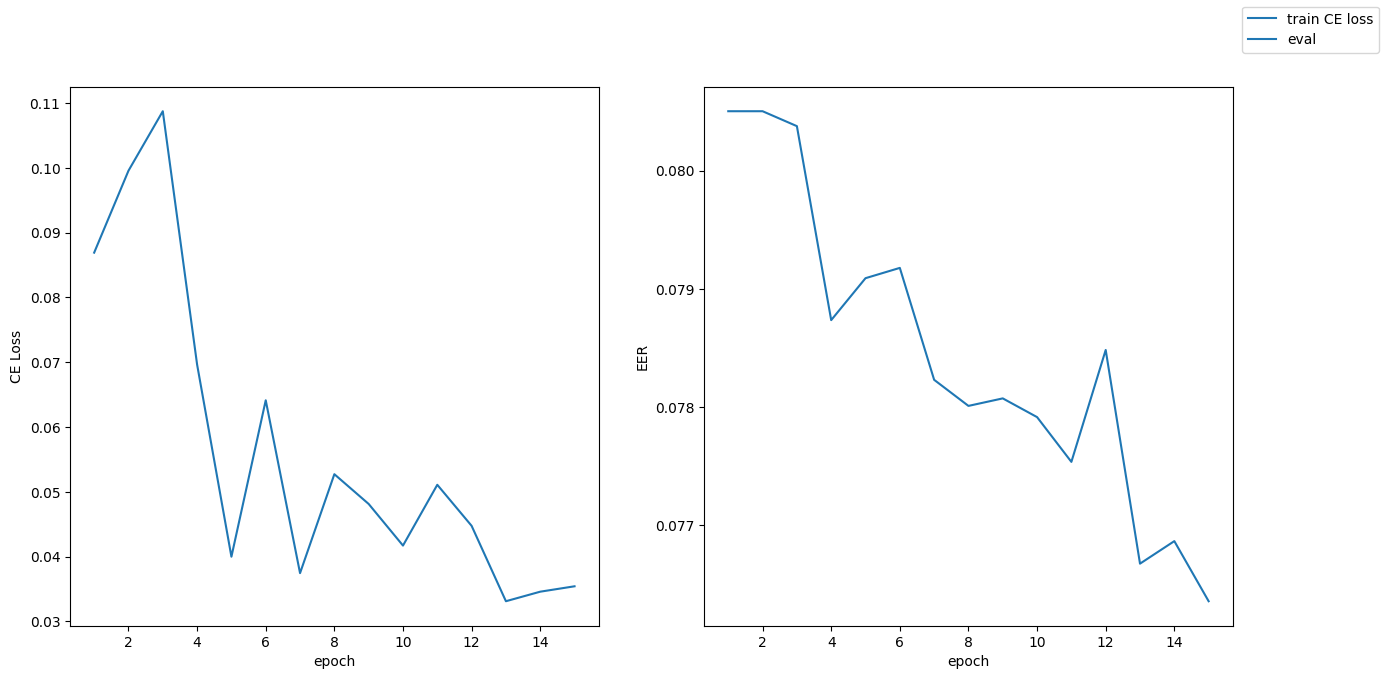

Epoch 15. Train loss 0.03540957646102321. Eval score 0.07635577595524191


In [ ]:
model = torch.load('model.pt').to(DEVICE)
opt = optim.Adam(model.parameters(), lr=0.00001)
train(model, opt, batch_size=75, train_fun=contrastive_train_stage, epochs=15)